This was an exercise in linear regression on a diabetes dataset. 

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

Number of Instances:
442

Number of Attributes:
First 10 columns are numeric predictive values

    Attribute Information:
    - Age
    - Sex
    - Body mass index
    - Average blood pressure
    - S1 (serum measurement 1)
    - S2 (serum measurement 2)
    - S3 (serum measurement 3)
    - S4 (serum measurement 4)
    - S5 (serum measurement 5)
    - S6 (serum measurement 6)

Target:	
Column 11 is a quantitative measure of disease progression one year after baseline

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times n_samples (i.e. the sum of squares of each column totals 1).

Source URL: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see: Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) “Least Angle Regression,” Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)


#### Import necessary tools.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import datasets
import xgboost as xgb
import seaborn as sns

In [2]:
def nulls_by_col(df):
# Calculate the number and percent of null values in each column.
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    return cols_missing

In [3]:
def nulls_by_row(df):
# Calculate the number of percent of null values in each row.
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing}).reset_index().groupby(['num_cols_missing','pct_cols_missing']).count().rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [4]:
def df_summary(df):
# Print information about the data including its shape, datatypes, number of values, 
# number of null values in each row and column, the number of unique rows, etc.
    print('--- Shape: {}'.format(df.shape))
    print('\n--- Info')
    display(df.info())
    print('\n--- Descriptions')
    display(df.describe(include='all'))
    print('\n--- Nulls By Column')
    display(nulls_by_col(df))
    print('\n--- Nulls By Row')
    display(nulls_by_row(df))
    print('\n---Unique Rows')
    display(df.apply(lambda x: x.nunique()))

In [5]:
def get_scaled_df(df):
# Return a dataframe that contains only numeric data so that we can scale it for XGBoost.
# This is not necessary for this data as it is already scaled, but it is part of a 
# pre-existing function that I wrote so I am leaving it here.
    numerics = ['int64', 'float64', 'float']
    scaled_df = df.select_dtypes(include=numerics)
    col = scaled_df.columns
    scaled_df = preprocessing.scale(scaled_df)
    scaled_df = pd.DataFrame(scaled_df, columns=col)
    return scaled_df

In [6]:
def xgb_rank(df,target_variable,feature_percent=80,mode='gain'):
    '''
    This function receives a dataframe and the target variable, and then returns 
    a sorted feature list, a sorted scaled feature list, and a dataframe. 
    
    For the input parameters:
        - feature_percent is the optional cut-off (default is 80 percent) for features 
        - mode is optional. The default value is 'gain' which shows the importance. 
          Another possible value for mode is 'weight.'
     
     For the returned:
        - feature_list, scaled_features: lists of features, both including those that 
          satisfy the cumulative percentage limit. 
        - scaled_df: dataframe that has all features in decending order 
        - importance_df: dataframe showing all cumulative percent rankings 
    '''    

    scaled_df = get_scaled_df(df) 
    xgb_params = {'max_depth': 8,'seed' : 123}
    dtrain = xgb.DMatrix(scaled_df, target_variable, feature_names=scaled_df.columns.values)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)
    importance_dict = model.get_score(importance_type=mode)
    sorted_importance_dict = sorted(importance_dict.items(), key=lambda kv: kv[1])
    importance_df = pd.DataFrame.from_dict(sorted_importance_dict)
    importance_df.columns = ['feature',mode] 
    importance_df.sort_values(mode, inplace = True) 
    importance_df['rank'] = importance_df[mode].rank(ascending = False)
    importance_df.sort_values('rank', inplace = True) 
    importance_df.set_index('rank', inplace = True)
    importance_df.reset_index(inplace=True) 
    importance_df[mode] = importance_df[mode].apply(lambda x: round(x, 2))
    importance_df['cum_sum'] = round(importance_df[mode].cumsum(),2)
    importance_df['cum_perc'] = round(100*importance_df.cum_sum/importance_df[mode].sum(),2)
    feature_list = []
    scaled_features = [] 

    for i in range((importance_df.shape[0])): 

        feature_name = importance_df.iloc[i,1].replace('scaled_','')
        scaled_name = 'scaled_' + feature_name
        importance_df.iloc[i,1] = feature_name
        cum_percent = importance_df.iloc[i,4]

        if cum_percent > feature_percent:
            break
        else:
            feature_list.append(feature_name)
            scaled_features.append(scaled_name)
    return feature_list, scaled_features, scaled_df, importance_df

#### Load the data and put the feature data and target data into a single dataframe.

In [7]:
diabetes = datasets.load_diabetes() # load data
data = np.c_[diabetes.data, diabetes.target]
columns = np.append(diabetes.feature_names, 'target')
df = pd.DataFrame(data, columns=columns)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


#### Print a summary of the data.

In [8]:
df_summary(df)

--- Shape: (442, 11)

--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
age       442 non-null float64
sex       442 non-null float64
bmi       442 non-null float64
bp        442 non-null float64
s1        442 non-null float64
s2        442 non-null float64
s3        442 non-null float64
s4        442 non-null float64
s5        442 non-null float64
s6        442 non-null float64
target    442 non-null float64
dtypes: float64(11)
memory usage: 38.1 KB


None


--- Descriptions


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000



--- Nulls By Column


,num_rows_missing,pct_rows_missing
age,0,0.0
sex,0,0.0
bmi,0,0.0
bp,0,0.0
s1,0,0.0
s2,0,0.0
s3,0,0.0
s4,0,0.0
s5,0,0.0
s6,0,0.0



--- Nulls By Row


,num_cols_missing,pct_cols_missing,num_rows
0,0,0.0,442



---Unique Rows


age        58
sex         2
bmi       163
bp        100
s1        141
s2        302
s3         63
s4         66
s5        184
s6         56
target    214
dtype: int64

#### This data has no null values.

#### Let's separate our data into our train and test dataframes.

In [9]:
X = df.drop(columns=['target'])
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Call the function, xgb_rank, to collect a list of features that account for 80% of the affect on the target variable in our training data as well as a dataframe of scaled training data and a datafram showing the importance of each feature in our training data.

In [10]:
feature_list, scaled_features, scaled_df, importance_df = xgb_rank(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Looks like this error is happening for pandas>=0.23.0 because the pandas Series.base property has been deprecated:
https://github.com/pandas-dev/pandas/blob/master/pandas/core/base.py#L779
from pandas-dev/pandas#20419 

Hopefully, XGBoost will fix this error.

In [11]:
print('feature_list: ', feature_list, '\n')
print('scaled_features: ', scaled_features, '\n')
print('\nscaled_df:')
display(scaled_df.head())
print('\ny_train:')
display(y_train.head())
print('\nimportance_df:')
display(importance_df)

feature_list:  ['s5', 'bmi', 's3', 's4'] 

scaled_features:  ['scaled_s5', 'scaled_bmi', 'scaled_s3', 'scaled_s4'] 


scaled_df:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.243962,1.025829,0.063645,1.210739,0.590736,0.383248,0.879258,-0.830724,0.075159,1.492971
1,-2.231571,-0.974821,-1.567897,-0.545562,-1.891763,-2.024327,0.567203,-1.598664,-0.869743,-0.102020
2,0.544026,1.025829,-0.708030,0.698485,-0.227028,0.050710,-0.212936,-0.062784,-0.305960,-1.025437
3,-0.131119,1.025829,0.041597,-1.789608,-0.227028,-0.335034,1.035286,-0.830724,-0.841330,-1.780959
4,1.369204,1.025829,0.438459,-0.106486,0.444707,0.576120,-0.056908,-0.062784,0.175777,0.065873



y_train:


74      85.0
26     137.0
45      53.0
389     51.0
154    197.0
Name: target, dtype: float64


importance_df:


,rank,feature,gain,cum_sum,cum_perc
0,1.0,s5,4605.48,4605.48,47.10
1,2.0,bmi,1673.09,6278.57,64.21
2,3.0,s3,558.55,6837.12,69.92
3,4.0,s4,557.12,7394.24,75.62
4,5.0,s6,521.27,7915.51,80.95
5,6.0,bp,512.64,8428.15,86.19
6,7.0,sex,417.06,8845.21,90.46
7,8.0,s1,400.20,9245.41,94.55
8,9.0,s2,375.20,9620.61,98.39
9,10.0,age,157.56,9778.17,100.00


#### Age is the least important feature with significantly less gain.

#### Let's create a dataframe that contains all of the scaled features plus the scaled target data.

In [12]:
full_scaled_df = scaled_df.copy()
full_scaled_df['target'] = preprocessing.scale(y_train)
display(full_scaled_df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.243962,1.025829,0.063645,1.210739,0.590736,0.383248,0.879258,-0.830724,0.075159,1.492971,-0.850668
1,-2.231571,-0.974821,-1.567897,-0.545562,-1.891763,-2.024327,0.567203,-1.598664,-0.869743,-0.102020,-0.186545
2,0.544026,1.025829,-0.708030,0.698485,-0.227028,0.050710,-0.212936,-0.062784,-0.305960,-1.025437,-1.259359
3,-0.131119,1.025829,0.041597,-1.789608,-0.227028,-0.335034,1.035286,-0.830724,-0.841330,-1.780959,-1.284902
4,1.369204,1.025829,0.438459,-0.106486,0.444707,0.576120,-0.056908,-0.062784,0.175777,0.065873,0.579751


#### Show Seaborn's PairGrid of the scaled data to explore it.

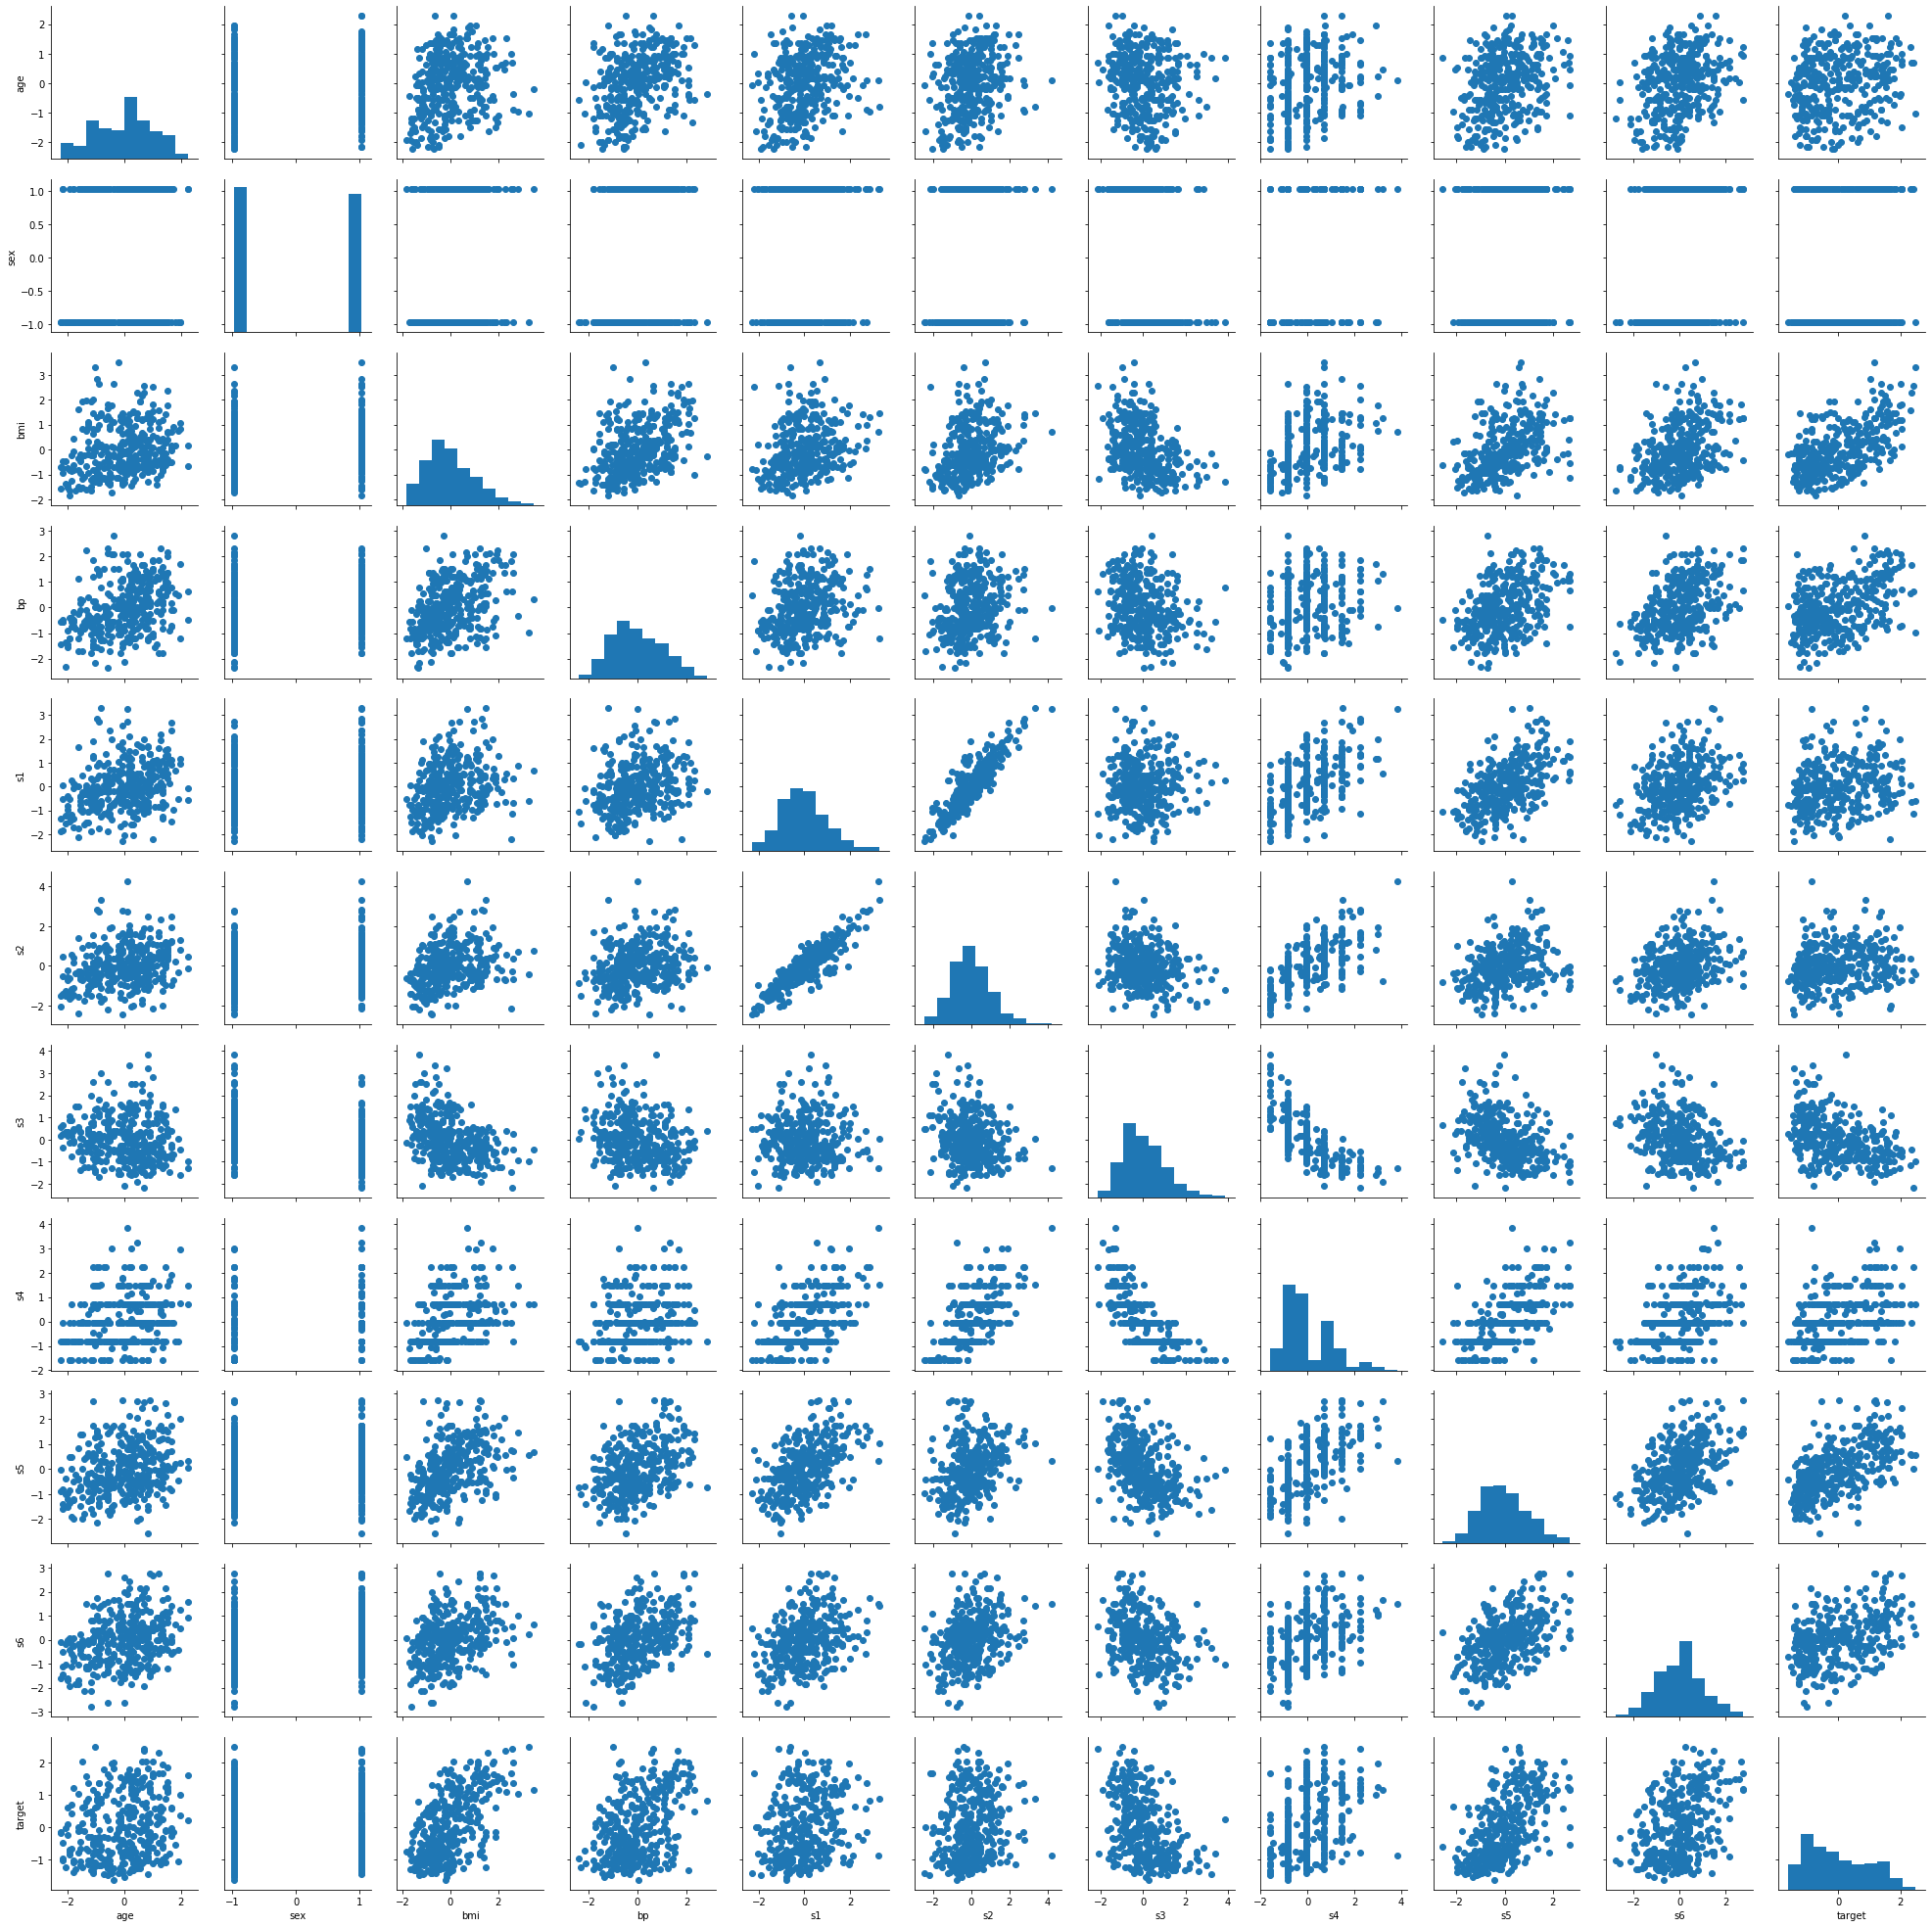

In [13]:
g = sns.PairGrid(full_scaled_df)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

#### And let's look at the correlation of the features.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

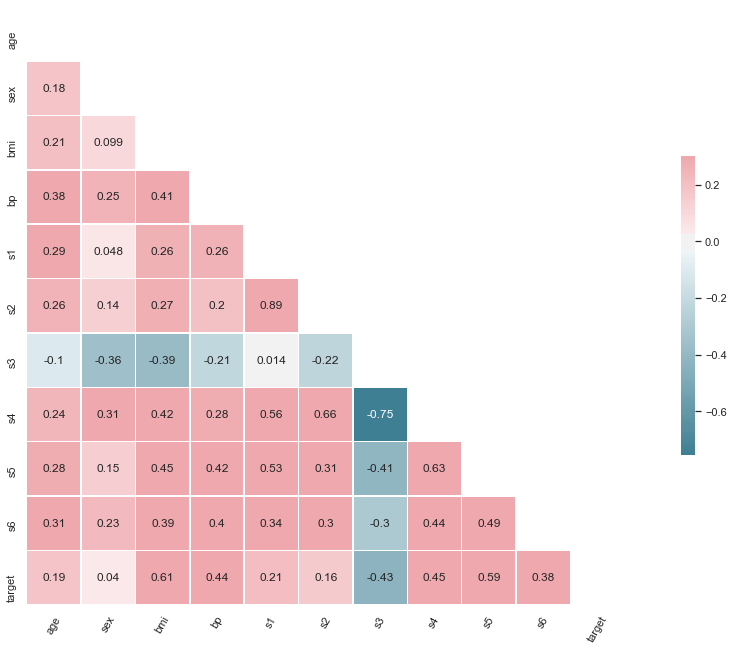

In [14]:
# Set the background to white so it won't show after adding the mask.
sns.set(style="white")

# Compute the correlation matrix from train_df.
corr = full_scaled_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=60)

#### Note the correlation of the features with the target varaiable differs from the results of XGBoost:
- bmi =  0.61
- s5  =  0.59
- s4  =  0.45
- bp  =  0.44
- s3  = -0.43
- s6  =  0.38
- s1  =  0.21
- age =  0.19
- s2  =  0.16
- sex =  0.04

```
importance_df (importance as ranked by XGBoost):
    rank	feature	gain	  cum_sum	cum_perc
0	1.0     s5	    4605.48	  4605.48	47.10
1	2.0     bmi	    1673.09	  6278.57	64.21
2	3.0     s3	     558.55	  6837.12	69.92
3	4.0     s4	     557.12	  7394.24	75.62
4	5.0     s6	     521.27	  7915.51	80.95
5	6.0     bp	     512.64	  8428.15	86.19
6	7.0     sex      417.06   8845.21	90.46
7	8.0     s1	     400.20	  9245.41	94.55
8	9.0     s2	     375.20	  9620.61	98.39
9	10.0    age	     157.56	  9778.17	100.00
```

#### The aren't completely different, but XGBoost is a boosted algorithm, so let's use it to make our decisions.


##### Serum measurements 1 and 2 (s1 and s2) are highly positively correlated at 0.89, but s1 ranks higher in importance. Drop s2.
##### Serum measurements 3 and 4 (s3 and s4) are highly negatively correlated at -0.75, but s3 ranks higher in importance. Drop s4.
##### Serum measurements 2 and 4 (s2 and s4) are fairly positively correlated at 0.66, but s4 ranks higher in importance. However, we already dropped s2 and s4!
##### Serum measurements 4 and 5 (s4 and s5) are fairly positively correlated at 0.63, but s5 ranks higher in importance. We already decided to drop s4.

#### So dropping s2 and s4.

```
importance_df:
    rank  feature  gain	
0	1.0   s5       4605.48	
1	2.0   bmi      1673.09	
2	3.0   s3        558.55	
4	5.0   s6        521.27	
5	6.0   bp        512.64	
6	7.0   sex       417.06	
7	8.0   s1        400.20	
9	10.0  age       157.56	
```

#### Age comes in last in importance and gives much less gain than the other features. Let's drop it. 
#### After playing for a bit, I realized our accuracy will increase if we also drop s1 and sex.

```
importance_df:
    rank  feature  gain	
0	1.0   s5       4605.48	
1	2.0   bmi      1673.09	
2	3.0   s3        558.55	
4	5.0   s6        521.27	
5	6.0   bp        512.64	
6	7.0   sex       417.06	
7	8.0   s1        400.20	
```
#### So we dropped s2, s4, age, s1, and sex.
#### That will leave us with seven features.

In [15]:
X_train = X_train.drop(columns=['s2', 's4', 'age', 's1', 'sex'])
print('X_train.head(2):')
display(X_train.head(2))
X_test = X_test.drop(columns=['s2', 's4', 'age', 's1', 'sex'])
print('X_test.head(2):')
display(X_test.head(2)) # Just to confirm we have the right features there 
                        # for when we do our test.
# And while we're at it, let's drop those columns from X.
X = df.drop(columns=['s2', 's4', 'age', 's1', 'sex'])
print('X.head(2):')
display(X.head(2)) # Again, just to confirm.

X_train.head(2):


,bmi,bp,s3,s5,s6
74,0.002417,0.056301,0.041277,0.003712,0.07348
26,-0.077342,-0.026328,0.026550,-0.042572,-0.00522


X_test.head(2):


,bmi,bp,s3,s5,s6
362,0.104809,0.070073,-0.024993,0.003712,0.040343
249,0.060618,0.052858,-0.017629,0.070211,0.007207


X.head(2):


,bmi,bp,s3,s5,s6,target
0,0.061696,0.021872,-0.043401,0.019908,-0.017646,151.0
1,-0.051474,-0.026328,0.074412,-0.068330,-0.092204,75.0


#### Let's look at the distribution of the target variable in our training data.

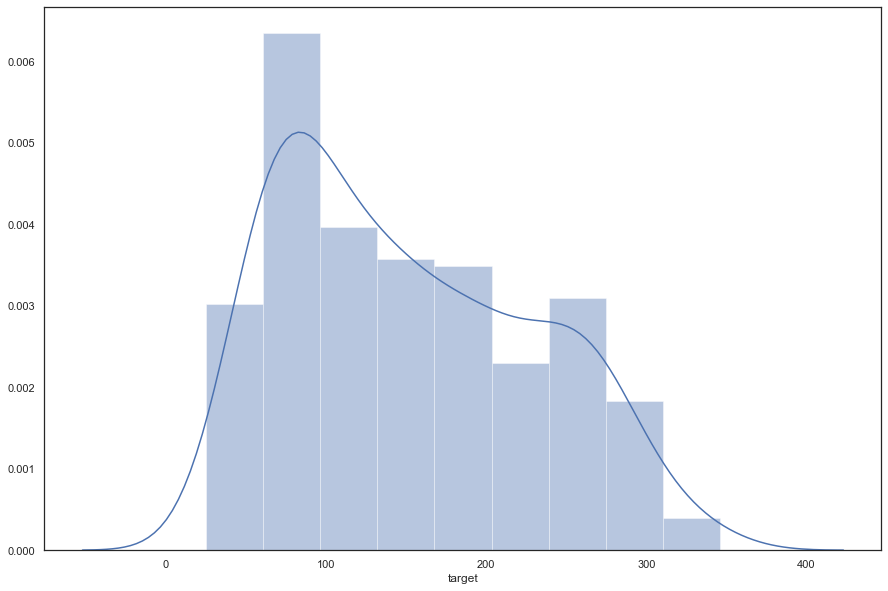

In [16]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(y_train)

#### Now we are ready to start developing our predictive model.

In [17]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
print(model.score(X_test, y_test))
#4. Check the regression metrics
y_pred = model.predict(X_test)

0.33259561360975065


In [18]:
#To retrieve the intercept:
print('The intercept is ', model.intercept_)
#For retrieving the slope:
print('The slope is ', model.coef_)

The intercept is  152.10068637362733
The slope is  [ 585.70729241  230.39380017 -218.7734868   500.34508331  -10.97272303]


#### Let's list the coefficients of each feature.

In [19]:
coeff_df = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])  
coeff_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
bmi,585.707292
s5,500.345083
bp,230.393800
s6,-10.972723
s3,-218.773487


#### Now let's compare the actual output values for X_test with the predicted values. But let's also slice of the top 25 rows so we can see them in our visualization below.

In [20]:
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
eval_df_top25 = eval_df.head(25)
display(eval_df_top25)

,Actual,Predicted
362,321.0,236.514384
249,215.0,238.691165
271,127.0,166.647367
435,64.0,114.161552
400,175.0,167.026067
403,275.0,242.846270
12,179.0,108.353585
399,232.0,199.514976
198,142.0,144.381380
205,99.0,214.715476


#### Let's visualize those 25 rows so we can see how close the actual and predicted values are.

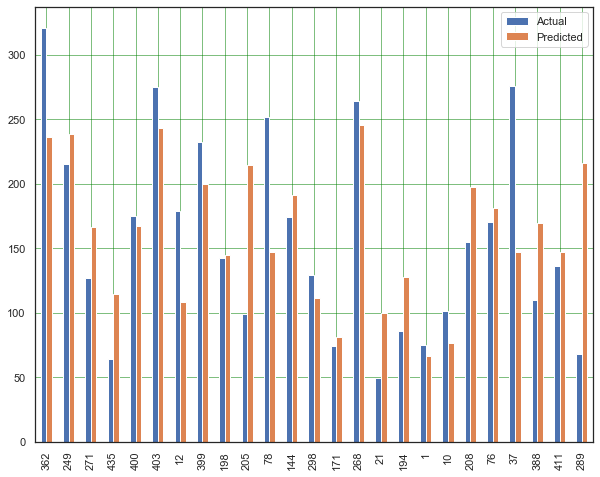

In [21]:
eval_df_top25.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### That's not looking as good as we'd like, but let's check out the evaluative statistics.

In [22]:
print('Mean value of the target variable is:', y_test.mean())
print('R-squared:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean/RMSE = ', np.sqrt(metrics.mean_squared_error(y_test, y_pred))/y_test.mean())

Mean value of the target variable is: 154.22471910112358
R-squared: 0.33259561360975065
Mean Absolute Error: 46.62708220122568
Mean Squared Error: 3422.4009925210116
Root Mean Squared Error: 58.501290520133075
mean/RMSE =  0.3793249931729451


#### RMSE

The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. *Lower values of RMSE indicate better fit.* RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.


You can see that the above value of root mean squared error is 58.501, which is 37.9% of the mean value which is 154.225. This means our algorithm was not very accurate.

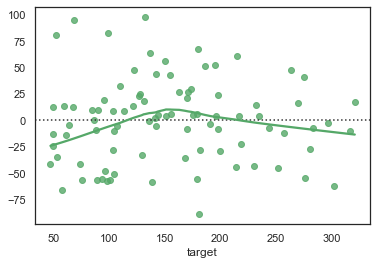

In [23]:
sns.residplot(y_test, y_pred, lowess=True, color="g")

#### This Residplot is a plot of the residuals after fitting our linear model. Obviously, this model has much room for improvement!

#### Let's try a logistic regression model.

In [52]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LogisticRegression(solver='newton-cg', multi_class='ovr')
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
print('score = ', model.score(X_test, y_test))
# 4. Check the regression metrics
y_pred = model.predict(X_test)

score =  0.0


#### I played with various values for solver and multi_class, but still only got a score of 0.0. 